In [1]:
from attr import dataclass
from qiskit import QuantumCircuit, transpile, ClassicalRegister, QuantumRegister
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2

from dotenv import load_dotenv

import json
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from typing import Tuple, List

load_dotenv()

True

In [2]:
# We will use IBM's QiskitRuntimeService
service = QiskitRuntimeService(token=os.environ["IBM_TOKEN"], channel="ibm_cloud", instance=os.environ["IBM_CRN"])
print(service.backends())

qiskit_runtime_service._discover_account:WARNING:2025-12-27 18:28:59,363: Loading account with the given token. A saved account will not be used.


[<IBMBackend('ibm_fez')>, <IBMBackend('ibm_marrakesh')>, <IBMBackend('ibm_torino')>]


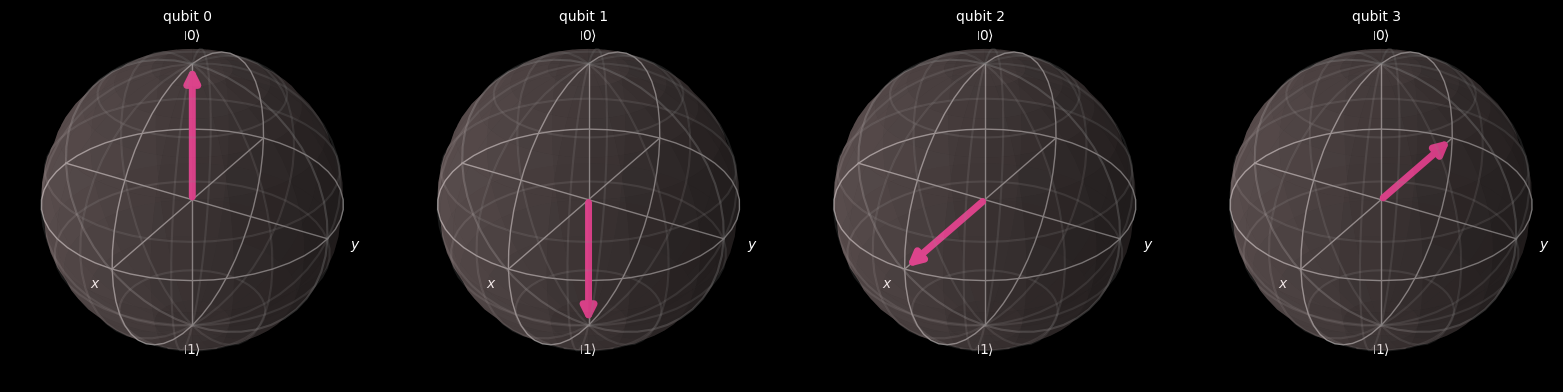

In [3]:
# Let us first draw the 4 states onto the Bloch sphere
def draw_bb84_states():
	"""
	Draws the four BB84 states on the Bloch sphere.
	"""
	qc = QuantumCircuit(4)
	qc.x((1, 3))
	qc.h((2, 3))
	state = Statevector.from_instruction(qc)
	plot_bloch_multivector(state)


draw_bb84_states()

In [4]:
@dataclass
class BB84Result:
	"""Container for BB84 protocol execution results"""
	n: int  # Desired key bits after reconciliation
	delta: int  # Security parameter
	t: int  # Absolute error threshold for aborting
	N: int  # Total bits sent
	eve_present: bool  # Whether an eavesdropper was present
	alice_bases: np.ndarray  # Alice's basis choices
	alice_bits: np.ndarray  # Alice's bit values
	bob_bases: np.ndarray  # Bob's basis choices
	bob_measured: np.ndarray  # Bob's measurements
	eve_bases: np.ndarray  # Eve's basis choices (if present)
	eve_measured: np.ndarray  # Eve's measurements (if present)
	match_bits: np.ndarray  # Bits where Alice and Bob's bases matched
	sifted_length: int  # Length after basis reconciliation
	check_bits_used: int  # Bits used for error checking
	errors_detected: int  # Number of errors in check bits
	final_key_length: int  # Length of final key
	aborted: bool  # Whether protocol was aborted
	backend_name: str  # Backend used
	execution_time: float  # Time taken (seconds)

BB84 Quantum Circuit:
Figure(10757.1x1538.44)
Total bits sent: 16
Alice:
	   Basis bits: [0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1]
	   Value bits: [1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1]
Eve:
	   Basis bits: [1 0 0 1 1 1 1 0 1 1 0 1 1 0 1 0]
	Measured bits: [0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 0]
Bob:
	   Basis bits: [1 0 0 0 0 1 0 1 0 1 0 0 1 1 0 1]
	Measured bits: [0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0]
Basis match:
	               [  x x x x   x x x   x   x x   x]
Check bits | Key bits:
	Alice: [1 1 0 1] | [1 0 0 1]
	Eve:   [1 1 1 1] | [1 1 0 1]
	Bob:   [1 1 0 0] | [0 1 0 1]
Matched bits:
	       [x x x  ] | [    x x]
Absolute errors in check bits: e=1
Too many mismatches? No (e=1 < t=2)
Eve's presence NOT detected... :(


BB84Result(n=4, delta=0, t=2, N=16, eve_present=True, alice_bases=array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1]), alice_bits=array([1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1]), bob_bases=array([1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1]), bob_measured=array([0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0]), eve_bases=array([1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]), eve_measured=array([0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0]), match_bits=array([False,  True,  True,  True,  True, False,  True,  True,  True,
       False,  True, False,  True,  True, False,  True]), sifted_length=8, check_bits_used=4, errors_detected=np.int64(1), final_key_length=4, aborted=np.False_, backend_name='ibm_fez', execution_time=2.236999034881592)

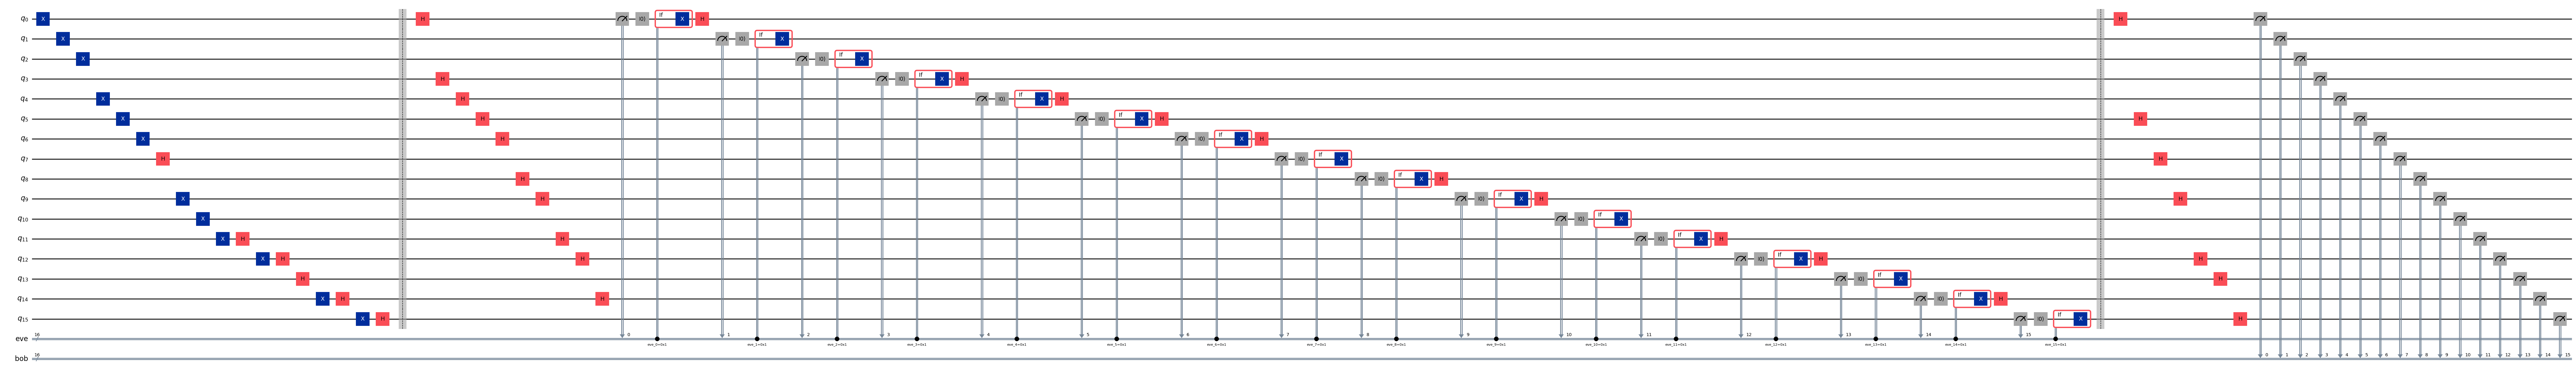

In [9]:
def encode_bit(qc: QuantumCircuit, qubit: int, basis: int, bit: int) -> None:
	"""
	Encodes a classical bit into a qubit.

	:param qc: 		QuantumCircuit
	:param qubit: 	qubit index; assumed initialized to |0⟩
	:param basis: 	bit denoting the basis: 0 for computational / rectilinear / Z-basis,
											1 for Hadamard / diagonal /  X-basis
	:param bit: 	classical bit (0 or 1) denoting the value to encode
	:return: 		None
	"""
	if basis not in [0, 1]:
		raise ValueError("Basis must be 0 or 1.")
	if bit not in [0, 1]:
		raise ValueError("Bit must be 0 or 1.")
	if bit:
		qc.x(qubit)  # Encode bit 1
	if basis:
		qc.h(qubit)  # Change to X-basis


def measure_qubit(qc: QuantumCircuit, qubit: int | QuantumRegister, c_bit: int | ClassicalRegister,
				  basis: int) -> None:
	"""
	Measures a qubit.

	:param qc: 		QuantumCircuit
	:param qubit: 	qubit index or QuantumRegister to measure
	:param c_bit: 	classical bit index or ClassicalRegister to store the measurement result
	:param basis: 	bit denoting the basis: 0 for computational / rectilinear / Z-basis,
											1 for Hadamard / diagonal /  X-basis
	:return: 		None
	"""
	if basis not in [0, 1]:
		raise ValueError("Basis must be 0 or 1.")
	if basis:
		qc.h(qubit)  # Change to Hadamard basis before measurement
	qc.measure(qubit, c_bit)


def run_bb84_protocol(
		n: int = 4, delta: int = 0, t: int = 2,
		eve: bool = False, run_on_hw: bool = False,
		draw_output: str = "text", draw_filename: str | None = None,
		sarg04: bool = False
) -> BB84Result:
	"""
	Constructs and simulates the use BB84 QKD protocol between Alice and Bob on random bit-strings.

	:param n: 				Number of key bits desired after basis reconciliation
	:param delta: 			Security parameter to increase the number of bits sent and ensure sufficient amount of bits after reconciliation
	:param t: 				Absolute error threshold for aborting the protocol
	:param eve: 			If True, simulates the presence of an eavesdropper (Eve) performing intercept-resend attack on all qubits
	:param run_on_hw: 		If True, runs the protocol on real hardware; otherwise, uses a simulator with noise model
	:param draw_output: 	Output format for circuit drawing ("text", "mpl", "latex", "latex_source")
	:param draw_filename: 	If provided, saves the drawn circuit to this filename
	:param sarg04: 			If True, uses SARG04 protocol instead of BB84

	:return: 				BB84Result object containing the results of the protocol execution
	"""

	N = (4 + delta) * n  # Total bits to send

	alice_bases = np.random.randint(2, size=N)  # Basis bits for Alice
	alice_bits = np.random.randint(2, size=N)  	# Value bits for Alice

	alice_disclosed_pairs = []
	if sarg04:
		# In SARG04, Alice chooses an extra bit in the other basis to disclose
		extra_bits = np.random.randint(2, size=N)
		for i in range(N):
			if alice_bases[i] == 0:
				alice_disclosed_pairs.append([alice_bits[i], extra_bits[i]])
			else:
				alice_disclosed_pairs.append([extra_bits[i], alice_bits[i]])
		alice_disclosed_pairs = np.array(alice_disclosed_pairs)

	bob_bases = np.random.randint(2, size=N)  	# Basis bits for Bob
	bob_bits = np.zeros(N, dtype=int)  			# Measured bits for Bob

	eve_bases = np.random.randint(2, size=N)  	# Basis bits for Eve (if present)
	eve_bits = np.zeros(N, dtype=int)  			# Measured bits for Eve

	qr = QuantumRegister(N, "q")
	cr_bob = ClassicalRegister(N, "bob")
	cr_eve = ClassicalRegister(N, "eve")

	if eve:
		qc = QuantumCircuit(qr, cr_eve, cr_bob)
	else:
		qc = QuantumCircuit(qr, cr_bob)

	for i in range(N):
		# Alice encodes her bit
		encode_bit(qc, i, alice_bases[i], alice_bits[i])
	qc.barrier()

	if eve:
		# If Eve is present, she intercepts and measures the qubit
		for i in range(N):
			if eve_bases[i]:
				qc.h(i)  # Change to Hadamard basis before measurement
			qc.measure(i, cr_eve[i])
			# Eve resends the qubit based on her measurement
			qc.reset(i)
			with qc.if_test((cr_eve[i], 1)):
				qc.x(i)  # Encode bit 1 if Eve measured 1
			if eve_bases[i]:
				qc.h(i)  # Change back to original basis

	qc.barrier()
	for i in range(N):
		# Bob measures the qubit
		measure_qubit(qc, i, cr_bob[i], bob_bases[i])

	# Draw the circuit
	print("BB84 Quantum Circuit:")
	print(qc.draw(output=draw_output, filename=draw_filename, justify="none", fold=-1))

	# Selecting a backend hardware as base
	real_backend = service.least_busy(operational=True, simulator=False)
	# Turn it into a simulator with noise model derived from backend's properties
	backend = AerSimulator.from_backend(real_backend)
	noise_model = NoiseModel.from_backend(backend)
	sim = AerSimulator(noise_model=noise_model)

	# Transpile the circuit for the selected backend
	tqc = transpile(
		qc,
		backend=backend if run_on_hw else sim,
		optimization_level=1,  # 0 = no optimization -> 3 = heavy optimization
		seed_transpiler=47 if run_on_hw else None
	)

	# Run the circuit on hardware or simulator
	if run_on_hw:
		with Session(backend) as session:
			sampler = SamplerV2(session)
			job = sampler.run([tqc], shots=1)
	else:
		job = sim.run(tqc, shots=1, seed_simulator=47)
	res = job.result()

	# Extract measured bits from the results
	counts = res.get_counts()
	if eve:
		for bitstring, _ in counts.items():
			# Qiskit returns bitstrings in reverse order
			parts = bitstring.split()
			if len(parts) == 2:
				# Format: "bob_bits eve_bits"
				bob_str, eve_str = parts
			else:
				# No space, split by length
				# Total length should be 2*N
				if len(bitstring) == 2 * N:
					bob_str = bitstring[:N]
					eve_str = bitstring[N:]
				else:
					raise ValueError(f"Unexpected bitstring format: {bitstring}")
			for i in range(N):
				bob_bits[i] = int(bob_str[N - 1 - i])  # Qiskit returns bitstrings in reverse order
				eve_bits[i] = int(eve_str[N - 1 - i])
	else:
		for bitstring, _ in counts.items():
			for i in range(N):
				bob_bits[i] = int(bitstring[N - 1 - i])  # Qiskit returns bitstrings in reverse order

	# Basis reconciliation
	match = alice_bases == bob_bases
	alice_sifted = alice_bits[match]
	bob_sifted = bob_bits[match]

	# Print results so far
	print(f"Total bits sent: {N}")
	print(f"Alice:")
	print(f"\t   Basis bits: {alice_bases}")
	print(f"\t   Value bits: {alice_bits}")
	if eve:
		print(f"Eve:")
		print(f"\t   Basis bits: {eve_bases}")
		print(f"\tMeasured bits: {eve_bits}")
	print(f"Bob:")
	print(f"\t   Basis bits: {bob_bases}")
	print(f"\tMeasured bits: {bob_bits}")
	print(f"Basis match:")
	print(f"\t               [{' '.join('x' if m else ' ' for m in match)}]")

	# If N' < 2n, abort the protocol
	if len(alice_sifted) < 2 * n:
		print(
			f"Not enough bits after basis reconciliation (N'={len(alice_sifted)} < 2n={2 * n}). Aborting protocol.")
		return BB84Result(
			n=n,
			delta=delta,
			t=t,
			N=N,
			eve_present=eve,
			alice_bases=alice_bases,
			alice_bits=alice_bits,
			bob_bases=bob_bases,
			bob_measured=bob_bits,
			eve_bases=eve_bases if eve else None,
			eve_measured=eve_bits if eve else None,
			match_bits=match,
			sifted_length=len(alice_sifted),
			check_bits_used=0,
			errors_detected=0,
			final_key_length=0,
			aborted=True,
			backend_name=real_backend.name,
			execution_time=res.time_taken
		)

	# Otherwise, truncate to 2n bits
	alice_sifted = alice_sifted[:2 * n]
	bob_sifted = bob_sifted[:2 * n]

	# Estimate absolute error
	# Use first half as check-bits, latter half as key-bits
	check_bits_alice = alice_sifted[:n]
	check_bits_bob = bob_sifted[:n]
	key_alice = alice_sifted[n:]
	key_bob = bob_sifted[n:]
	error_abs = np.sum(check_bits_alice != check_bits_bob)

	# Print final results
	print("Check bits | Key bits:")
	print(f"\tAlice: {check_bits_alice} | {key_alice}")
	if eve:
		check_bits_eve = eve_bits[match][:n]
		key_eve = eve_bits[match][n:2 * n]
		print(f"\tEve:   {check_bits_eve} | {key_eve}")
	print(f"\tBob:   {check_bits_bob} | {key_bob}")
	print("Matched bits:")
	print(
		f"\t       [{' '.join('x' if a == b else ' ' for a, b in zip(check_bits_alice, check_bits_bob))}] | [{' '.join('x' if a == b else ' ' for a, b in zip(key_alice, key_bob))}]")
	print(f"Absolute errors in check bits: e={error_abs}")
	print(f"Too many mismatches? {'Yes (e={error_abs} >=' if error_abs > t else f'No (e={error_abs} <'} t={t})")
	if eve:
		if error_abs > t:
			print("Eve's presence detected! Aborting protocol. :)")
		else:
			print("Eve's presence NOT detected... :(")

	return BB84Result(
		n=n,
		delta=delta,
		t=t,
		N=N,
		eve_present=eve,
		alice_bases=alice_bases,
		alice_bits=alice_bits,
		bob_bases=bob_bases,
		bob_measured=bob_bits,
		eve_bases=eve_bases if eve else None,
		eve_measured=eve_bits if eve else None,
		match_bits=match,
		sifted_length=len(alice_sifted),
		check_bits_used=n,
		errors_detected=error_abs,
		final_key_length=len(key_alice),
		aborted=error_abs > t,
		backend_name=real_backend.name,
		execution_time=res.time_taken
	)


eve = True
run_bb84_protocol(n=4, delta=0, t=2, eve=eve, run_on_hw=False, draw_output="mpl", draw_filename=f"bb84_circuit_{'with' if eve else 'no'}_eve.png")